In [1]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(1)

In [3]:
class SentenceEncoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, device=torch.device("cpu")):
        super().__init__()
        self.max_seqlen = 7
        self.input_dim = self.output_dim = input_dim
        self.hidden_dim = hidden_dim

        # for encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim)
        self.m = nn.Linear(hidden_dim, self.hidden_dim)
        self.v = nn.Linear(hidden_dim, self.hidden_dim)
        
        # for decoder
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim)
        self.decoder_fc = nn.Linear(hidden_dim, self.output_dim)

        self.init_hidden()
        self.to(device)
        self.device = device

    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        hidden_shape = (1, 1, self.hidden_dim)
        self.encoder_hidden = (torch.zeros(*hidden_shape), torch.zeros(*hidden_shape))
        self.decoder_hidden = (torch.zeros(*hidden_shape), torch.zeros(*hidden_shape))
        return self
    
    def encode(self, sequence):
        seq = sequence.unsqueeze(1)  # add the dim for batch-size
        seq = seq.to(self.device)
        encoder_out, self.encoder_hidden = self.encoder_lstm(seq, self.encoder_hidden)
        mu, logvar = self.m(encoder_out), self.v(encoder_out)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, sequence):
        decoded, self.encoder_hidden = self.decoder_lstm(sequence, self.decoder_hidden)
        return decoded
    
    def is_similar(self, src, trg):
        _s = numpy.array(src.data)
        _t = numpy.array(trg.data)
        eps = numpy.linalg.norm(_s) * 0.01
        return (numpy.linalg.norm(_s - _t) < eps)

    def forward(self, sequence):
        mu, logvar = self.encode(sequence)
        z = self.reparameterize(mu, logvar)
        embeded = z[-1].unsqueeze(1)  # add the dim for batch-size
        
        y = []
        d = embeded
        for t in range(self.max_seqlen):
            # print(f"t: {t} d.shape: {d.shape}")
            d = self.decode(d)
            _x = self.decoder_fc(d)
            y.append(_x)
            
            eos = sequence[-1]
            is_eos = self.is_similar(_x, eos)
            if is_eos:
                break
        y = torch.cat(y)
        return y, mu, logvar

In [4]:
sequence = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
sequence = torch.cat(sequence)
sequence

tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661],
        [-1.5228,  0.3817, -1.0276],
        [-0.5631, -0.8923, -0.0583],
        [-0.1955, -0.9656,  0.4224]])

In [5]:
se = SentenceEncoder(3, 2)
y, mu, logvar = se(sequence)

looper = (["y", "mu", "logvar"], [y, mu, logvar])
for nm, v in zip(*looper):
    print(f"{nm}: {v.shape}")

y: torch.Size([7, 1, 3])
mu: torch.Size([5, 1, 2])
logvar: torch.Size([5, 1, 2])


In [6]:
def reversed_tensor(tensor, device=torch.device("cpu")):
    indices = [i for i in range(tensor.size(0)-1, -1, -1)]
    indices = torch.LongTensor(indices).to(device)
    inverted = tensor.index_select(0, indices)
    return inverted

In [7]:
def get_loss(y, t, mu, logvar):
    if len(t.shape) == 2:
        t = t.unsqueeze(1)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    mse = nn.MSELoss()

    n = min(len(y), len(t))
    _y, _t = y[:n], t[:n]

    loss_mse = mse(_y, _t)
    loss_cos = 0.25 * torch.mean(1 - cos(_y, _t))
    loss_cor = 0.25 * torch.mean(1 - cos(_y - torch.mean(_y), _t - torch.mean(_t)))
    loss_similarity = loss_cos + loss_cor
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = kl_div + loss_mse + loss_similarity
    return loss

In [8]:
t = reversed_tensor(sequence).unsqueeze(1)
loss = get_loss(y, t, mu, logvar)
print(loss)
loss.backward()

tensor(0.9701)


## train

In [9]:
# device = torch.device("cuda:0")
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [10]:
def get_toydata(device):
    toydata = []
    for _n in range(n_data):
        t = numpy.random.randint(5) + 2
        seq = [torch.randn(1, 3) for _t in range(t)]  # make a sequence of length 5
        seq = torch.cat(seq)
        seq = seq.to(device)
        toydata.append(seq)
    return toydata

In [11]:
model = SentenceEncoder(3, 2, device)
print(model)
n_data = 10

data = get_toydata(device)
print(data)

teacher = [reversed_tensor(seq, device) for seq in data]

training_data = (data, teacher)

optim_params = {
    "params": model.parameters(),
    "weight_decay": 0
}
# optimizer = torch.optim.SGD(lr=0.1, **optim_params)
optimizer = torch.optim.Adam(lr=0.001, **optim_params)

SentenceEncoder(
  (encoder_lstm): LSTM(3, 2)
  (m): Linear(in_features=2, out_features=2, bias=True)
  (v): Linear(in_features=2, out_features=2, bias=True)
  (decoder_lstm): LSTM(2, 2)
  (decoder_fc): Linear(in_features=2, out_features=3, bias=True)
)
[tensor([[-0.1602,  1.1192, -0.1277],
        [-0.9501,  1.4064, -0.4549],
        [ 0.5838, -0.9699, -0.9469]], device='cuda:1'), tensor([[-0.2330,  0.6424,  0.0899],
        [ 1.4849,  0.0087, -0.4798],
        [ 0.9808,  0.2786,  1.6559],
        [ 0.3677,  2.5169,  0.1226],
        [-0.3431, -0.8052, -0.8996],
        [-0.1665, -1.2544,  0.4524]], device='cuda:1'), tensor([[-1.8438, -0.6672,  1.3412],
        [-0.6061, -1.3228,  0.5589],
        [-0.0543,  0.5147,  0.3752],
        [ 0.4385, -0.9105, -0.8118],
        [ 0.7256,  0.0306,  0.8803]], device='cuda:1'), tensor([[ 0.5456, -0.5979,  0.3257],
        [-0.5642, -1.1759,  0.5865],
        [-0.0984, -2.1864, -1.3009],
        [ 0.5864,  0.0956,  1.4656]], device='cuda:1'), ten

In [14]:
def train(model, training_data, max_epoch=10):
    loss_records = []
    for epoch in range(max_epoch):
        loss_mean = 0
        for s, t in zip(*training_data):
            model.zero_grad()
            model.init_hidden()

            y, mu, logvar = model(s)

            loss = get_loss(y, t, mu, logvar)
            loss_mean += loss
            loss.backward()
            optimizer.step()
        loss_mean /= len(training_data[0])
        print(f"epoch: {epoch:05d} loss_mean: {loss_mean}")
        loss_records.append(loss_mean)
    return loss_records

loss_records = train(model, training_data, max_epoch=1000)

RuntimeError: CUDNN_STATUS_EXECUTION_FAILED

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

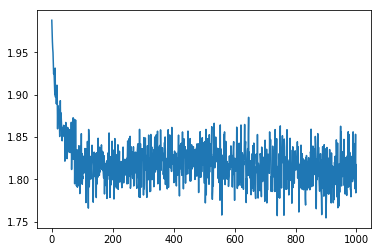

In [21]:
x = range(len(loss_records))
y = loss_records
plt.plot(x, y)

In [19]:
device

device(type='cuda')

## test

In [82]:
input1 = torch.randn(7, 5)
input2 = torch.randn(7, 5)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
output.shape

torch.Size([7])

In [89]:
tensor = torch.rand(10) # your tensor
print(tensor)
indices = [i for i in range(tensor.size(0)-1, -1, -1)]
indices = torch.LongTensor(indices)
inverted_tensor = tensor.index_select(0, indices)
inverted_tensor

tensor([ 0.8408,  0.8186,  0.3792,  0.5894,  0.4626,  0.4036,  0.8759,
         0.9513,  0.8621,  0.0946])


tensor([ 0.0946,  0.8621,  0.9513,  0.8759,  0.4036,  0.4626,  0.5894,
         0.3792,  0.8186,  0.8408])

In [23]:
r = numpy.random.random(3)
numpy.mean(list(r))

0.3948325437437648